# Imports

In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy
from torchsummary import summary

In [1]:
#!pip install gdown
#!gdown https://drive.google.com/uc?id=1YJlcW79qAxHkpXv8BoDNTwPYuuAYk13P

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#!unzip /content/bossbase_divided_40k.zip
!unzip /content/drive/MyDrive/bossbase/bossbase_divided_40k.zip

# Helper classes and functions



In [ ]:
from sklearn import metrics
import numpy as np

class ModelTrainer:
    def __init__(self, train_loader, test_loader, batch_size):
        self.batch_size = batch_size
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def train(self, model, optimizer, 
              loss_fn=torch.nn.functional.cross_entropy, n_epochs=100,
              n_samples_train=None, n_samples_test=None):
        if n_samples_train is None:
          n_samples_train = len(self.train_loader)
        if n_samples_test is None:
          n_samples_test = len(self.test_loader)

        self.logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': [],
                     'train_tp': [], 'train_tn': [], 'train_fp': [], 'train_fn': [],
                     'test_tp': [], 'test_tn': [], 'test_fp': [], 'test_fn': []}
        model = model.to(self.device)
        correct, numel = 0, 0

        tp, tn, fp, fn = 0, 0, 0, 0

        print("Start")
        for e in range(1, n_epochs + 1):
            print('Epoch: ', e)
            model.train()
            for i, (x, y) in enumerate(self.train_loader):
                x = x.to(self.device)
                y = y.to(self.device)
                if i*self.batch_size > n_samples_train:
                  break
                optimizer.zero_grad()
                output = model(x)
                y_pred = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1)
                correct += torch.sum(y_pred == y).item()
                numel += self.batch_size
                loss = loss_fn(output, y)
                loss.backward()
                optimizer.step()

                confusion_matrix = metrics.confusion_matrix(y.cpu(), y_pred.cpu())
                tp += confusion_matrix[1][1]
                tn += confusion_matrix[0][0]
                fp += confusion_matrix[0][1]
                fn += confusion_matrix[1][0]

            self.logs["train_tp"].append(tp)
            self.logs["train_tn"].append(tn)
            self.logs["train_fp"].append(fp)
            self.logs["train_fn"].append(fn)
            tp, tn, fp, fn = 0, 0, 0, 0

            print('train_loss: ', loss.item())
            print('train_accuracy: ', correct / numel)

            self.logs['train_loss'].append(loss.item())
            self.logs['train_accuracy'].append(correct / numel)
            correct, numel = 0, 0

            model.eval()
            with torch.no_grad():
                for i, (x_test, y_test) in enumerate(self.test_loader):
                    x_test = x_test.to(self.device)
                    y_test = y_test.to(self.device)

                    if i*self.batch_size > n_samples_test:
                      break
                    output = model(x_test)
                    y_pred = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1)
                    correct += torch.sum(y_pred == y_test).item()
                    numel += self.batch_size

                    confusion_matrix = metrics.confusion_matrix(y.cpu(), y_pred.cpu())
                    tp += confusion_matrix[1][1]
                    tn += confusion_matrix[0][0]
                    fp += confusion_matrix[0][1]
                    fn += confusion_matrix[1][0]

                loss = loss_fn(output, y_test)

            self.logs["test_tp"].append(tp)
            self.logs["test_tn"].append(tn)
            self.logs["test_fp"].append(fp)
            self.logs["test_fn"].append(fn)
            tp, tn, fp, fn = 0, 0, 0, 0

            print('test_loss: ', loss.item())
            print('test_accuracy: ', correct / numel)

            self.logs['test_loss'].append(loss.item())
            self.logs['test_accuracy'].append(correct / numel)
            correct, numel = 0, 0

        return self.logs

def show_results(orientation='horizontal', accuracy_bottom=None, loss_top=None, **histories):
    if orientation == 'horizontal':
        f, ax = plt.subplots(1, 2, figsize=(16, 5))
    else:
        f, ax = plt.subplots(2, 1, figsize=(16, 16))
    for i, (name, h) in enumerate(histories.items()):
        if len(histories) == 1:
            ax[0].set_title("Best test accuracy: {:.2f}% (train: {:.2f}%)".format(
                max(h['test_accuracy']) * 100,
                max(h['train_accuracy']) * 100
            ))
        else:
            ax[0].set_title("Accuracy")
        ax[0].plot(h['train_accuracy'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[0].plot(h['test_accuracy'], color='C%s' % i, label='%s test' % name)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('accuracy')
        if accuracy_bottom:
            ax[0].set_ylim(bottom=accuracy_bottom)
        ax[0].legend()

        if len(histories) == 1:
            ax[1].set_title("Minimal train loss: {:.4f} (test: {:.4f})".format(
                min(h['train_loss']),
                min(h['test_loss'])
            ))
        else:
            ax[1].set_title("Loss")
        ax[1].plot(h['train_loss'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[1].plot(h['test_loss'], color='C%s' % i, label='%s test' % name)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('loss')
        if loss_top:
            ax[1].set_ylim(top=loss_top)
        ax[1].legend()

    plt.show()

def show_type_errors(orientation='horizontal', **histories):
    if orientation == 'horizontal':
        f, ax = plt.subplots(1, 2, figsize=(16, 5))
    else:
        f, ax = plt.subplots(2, 1, figsize=(16, 16))
    for i, (name, h) in enumerate(histories.items()):
        ax[0].set_title("False Positive Rate")
        train_fp_rate = np.divide(h['train_fp'], np.add(h['train_fp'], h['train_tn']))
        test_fp_rate = np.divide(h['test_fp'], np.add(h['test_fp'], h['test_tn']))
        ax[0].plot(train_fp_rate, color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[0].plot(test_fp_rate, color='C%s' % i, label='%s test' % name)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('FP rate')
        ax[0].legend()
    
        ax[1].set_title("False Negative Rate")
        train_fn_rate = np.divide(h['train_fn'], np.add(h['train_fn'], h['train_tp']))
        test_fn_rate = np.divide(h['test_fn'], np.add(h['test_fn'], h['test_tp']))
        ax[1].plot(train_fn_rate, color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[1].plot(test_fn_rate, color='C%s' % i, label='%s test' % name)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('FN rate')
        ax[1].legend()

    plt.show()

# Bossbase Dataset

## Train

In [ ]:
DATASET_PATH = '/content/bossbase_1.01_divided_pytorch/train'

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),                                         
    torchvision.transforms.ToTensor()
])
bossbase_train = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=transforms)
print(bossbase_train.class_to_idx)

{'cover': 0, 'stego': 1}


## Test

In [ ]:
import json
import os

class IStegoTestDataset(torch.utils.data.Dataset):
    MAPPING = {'cover': 0, 'stego': 1}

    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = self.preprocess_labels_df(pd.read_json(labels_file))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def preprocess_labels_df(self, df):
        tmp1 = pd.DataFrame({'file_name': df["cover"], 'label': pd.Series([self.MAPPING['cover']] * 4052)})
        tmp2 = pd.DataFrame({'file_name': df["stego"], 'label': pd.Series([self.MAPPING['stego']] * 4052)})
        r = tmp1.append(tmp2, ignore_index=True).sort_values(by='file_name', ignore_index=True)
        return r

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = torchvision.io.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
#LABELS = "/content/drive/MyDrive/istego100k/ss_test/SameSourceTestSetLabels.json"
#DATASET_TEST = "/content/drive/MyDrive/istego100k/ss_test/test"

#transforms = torchvision.transforms.Compose([
#    torchvision.transforms.ConvertImageDtype(torch.float)
#])
#istego_ss_test = IStegoTestDataset(labels_file=LABELS, img_dir=DATASET_TEST, transform=transforms)
#print(istego100k_test_dataset.class_to_idx)
DATASET_PATH = '/content/bossbase_1.01_divided_pytorch/test'

bossbase_test = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=transforms)
print(bossbase_test.class_to_idx)

{'cover': 0, 'stego': 1}


# Naive CNN

In [ ]:
class Squeeze(torch.nn.Module):
  def forward(self, x):
    return x.squeeze()

  
cnn1 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, 5, stride=1, padding=2),
    torch.nn.Tanh(), 
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(16, 30, 5, stride=1, padding=2),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(30, 32, 5, stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(32, 64, 3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(64, 128, 3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(16),
    Squeeze()
)

classifier = torch.nn.Sequential(
    torch.nn.Linear(128, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 2),
    #torch.nn.Sigmoid()
)

In [ ]:
BATCH_SIZE=64
NUM_SAMPLES=10000
LR = 5e-3
EPOCHS = 20

model = torch.nn.Sequential(
    cnn1,
    classifier
)

train_loader = torch.utils.data.DataLoader(bossbase_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(bossbase_test, batch_size=BATCH_SIZE, shuffle=True)

trainer = ModelTrainer(train_loader, test_loader, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
summary(model.cuda(), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             416
              Tanh-2         [-1, 16, 256, 256]               0
         AvgPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 30, 128, 128]          12,030
              Tanh-5         [-1, 30, 128, 128]               0
         AvgPool2d-6           [-1, 30, 64, 64]               0
            Conv2d-7           [-1, 32, 64, 64]          24,032
              ReLU-8           [-1, 32, 64, 64]               0
         AvgPool2d-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          18,496
             ReLU-11           [-1, 64, 32, 32]               0
        AvgPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
             ReLU-14          [-1, 128,

In [ ]:
logs = trainer.train(model, optimizer, n_epochs=EPOCHS, n_samples_train=NUM_SAMPLES, n_samples_test=NUM_SAMPLES)

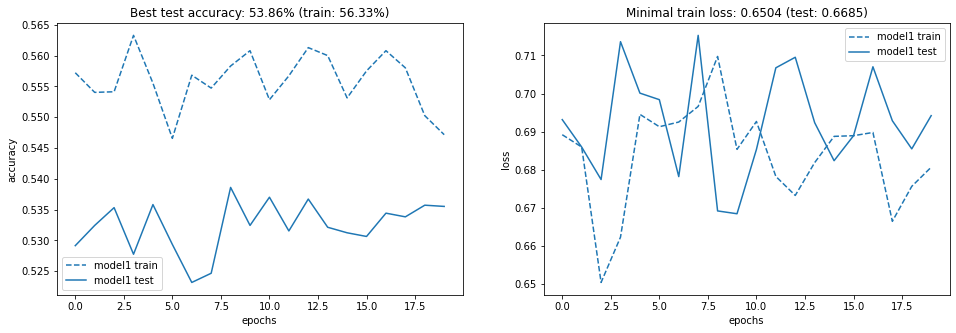

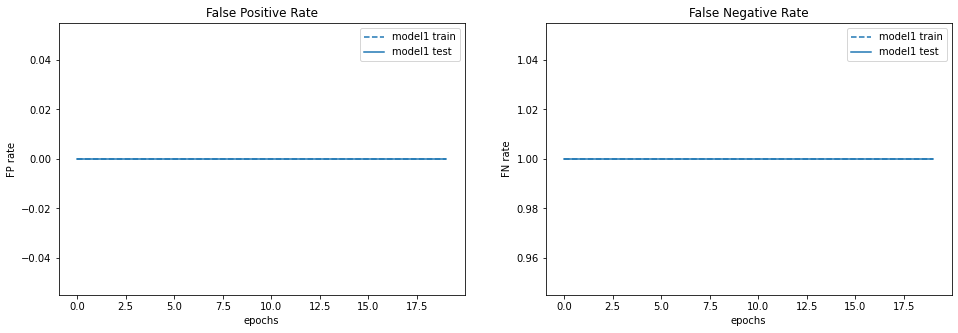

In [ ]:
show_results(model1=logs)
show_type_errors(model1=logs)

# High-Pass filter

In [ ]:
class HPF(torch.nn.Module):
  def __init__(self, kernel):
    super(HPF, self).__init__()

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.kernel = kernel
    self.kernel = self.kernel.view(1, 1, 5, 5).to(device=device, dtype=torch.float)
    self.kernel = torch.autograd.Variable(self.kernel, requires_grad=False)

  def forward(self, x):
    out = torch.nn.functional.conv2d(x, self.kernel, stride=1, padding=2)
    return out

In [ ]:
BATCH_SIZE=64
NUM_SAMPLES=10000
LR = 5e-3
EPOCHS = 20

kernel = torch.tensor([
       [-1,2,-2,2,-1],
		   [2,-6,8,-6,2],
		   [-2,8,-12,8,-2],
		   [2,-6,8,-6,2],
		   [-1,2,-2,2,-1]])/12.

model_hpf = torch.nn.Sequential(
     HPF(kernel),
     cnn1,
     classifier
)

train_loader = torch.utils.data.DataLoader(bossbase_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(bossbase_test, batch_size=BATCH_SIZE, shuffle=True)

trainer = ModelTrainer(train_loader, test_loader, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model_hpf.parameters(), lr=LR)

In [ ]:
logs_hpf = trainer.train(model_hpf, optimizer, n_epochs=EPOCHS, n_samples_train=NUM_SAMPLES, n_samples_test=NUM_SAMPLES)

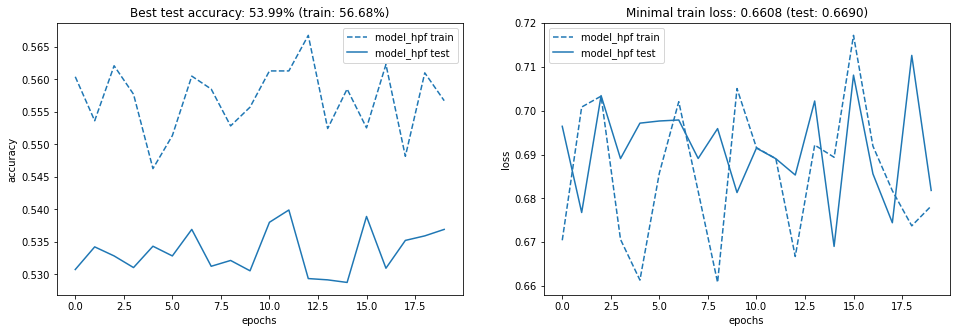

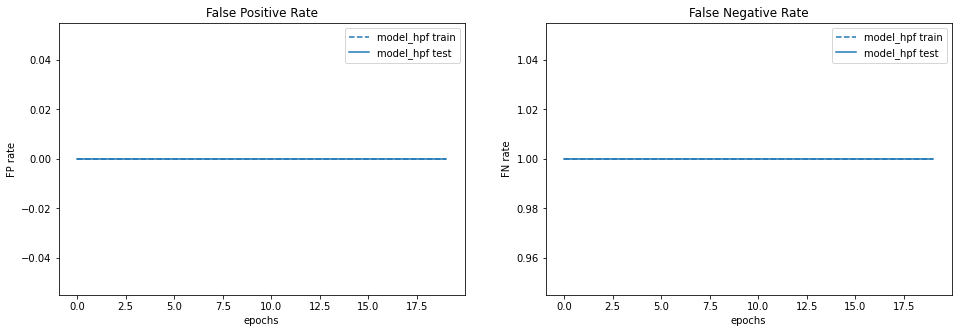

In [ ]:
show_results(model_hpf = logs_hpf)
show_type_errors(model_hpf = logs_hpf)

In [ ]:
print(logs_hpf["test_tp"])
print(logs_hpf["test_fp"])
print(logs_hpf["test_tn"])
print(logs_hpf["test_fn"])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[5966, 5338, 5966, 5338, 5652, 5495, 6123, 6594, 6437, 6280, 5652, 5181, 3768, 5495, 5495, 5181, 5809, 5181, 6280, 5495]
[4082, 4710, 4082, 4710, 4396, 4553, 3925, 3454, 3611, 3768, 4396, 4867, 6280, 4553, 4553, 4867, 4239, 4867, 3768, 4553]


In [ ]:
from pathlib import Path
import random

class RandomPairedSampler(torch.utils.data.sampler.Sampler):
    
    def __init__(self, data_source, generator=None) -> None:
        self.data_source = data_source
        self.generator = generator
        files = data_source.imgs
        covers_ids = list(range(24000))
        #stegos_ids = range(24000, len(files))

        self.paired_stegos = []
        for c in covers_ids:
          s = -1
          for i in range(24000, len(files)):
            if files[c][0][51:] ==files[i][0][51:]:
              s = i
              break;
          self.paired_stegos.append(s)

    def __iter__(self):
        covers_ids = list(range(24000))
        random.shuffle(covers_ids)
        indices = []

        for c in covers_ids:
          s = self.paired_stegos[c]
          if s == -1:
            indices.append(c)
          else:
            p = [c, s]
            random.shuffle(p)
            indices = indices + p
        return iter(indices)

    def __len__(self) -> int:
        return len(self.data_source)
  

In [ ]:
files = bossbase_train.imgs
for i in range(20):
  print()
  print(files[i])
  print(files[24000+i])

filename = files[24001][0]
print(filename[51:])
print(len(filename))

In [ ]:
train_sampler = RandomPairedSampler(bossbase_train)
test_sampler = RandomPairedSampler(bossbase_test)

In [ ]:
BATCH_SIZE=64
NUM_SAMPLES=10000
LR = 5e-3
EPOCHS = 10

model_paired_hpf = torch.nn.Sequential(
     HPF(kernel),
     cnn1,
     classifier
)

train_loader = torch.utils.data.DataLoader(bossbase_train, batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(bossbase_test, batch_size=BATCH_SIZE, shuffle=False, sampler=test_sampler)

trainer = ModelTrainer(train_loader, test_loader, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model_paired_hpf.parameters(), lr=LR)

In [ ]:
logs_paired_hpf = trainer.train(model_paired_hpf, optimizer, n_epochs=EPOCHS, n_samples_train=NUM_SAMPLES, n_samples_test=NUM_SAMPLES)

Start
Epoch:  1
train_loss:  0.689088761806488
train_accuracy:  0.5558320063694268
test_loss:  0.7237209677696228
test_accuracy:  0.35698646496815284
Epoch:  2
train_loss:  0.6894693374633789
train_accuracy:  0.5555334394904459
test_loss:  0.7224103212356567
test_accuracy:  0.35828025477707004
Epoch:  3
train_loss:  0.6816080212593079
train_accuracy:  0.5573248407643312
test_loss:  0.7341187000274658
test_accuracy:  0.35658837579617836
Epoch:  4
train_loss:  0.6853236556053162
train_accuracy:  0.5585191082802548
test_loss:  0.730846643447876
test_accuracy:  0.35788216560509556
Epoch:  5
train_loss:  0.6887716054916382
train_accuracy:  0.5589171974522293
test_loss:  0.7367910742759705
test_accuracy:  0.36186305732484075
Epoch:  6
train_loss:  0.6888443827629089
train_accuracy:  0.5553343949044586
test_loss:  0.7191796898841858
test_accuracy:  0.35768312101910826
Epoch:  7
train_loss:  0.6853590607643127
train_accuracy:  0.5589171974522293
test_loss:  0.7458287477493286
test_accuracy:  0

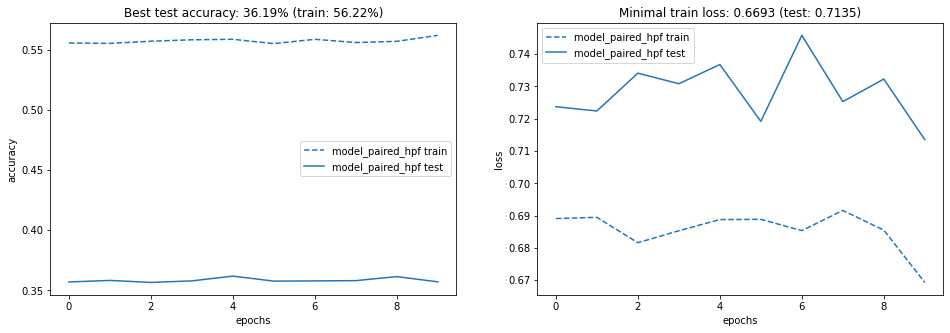

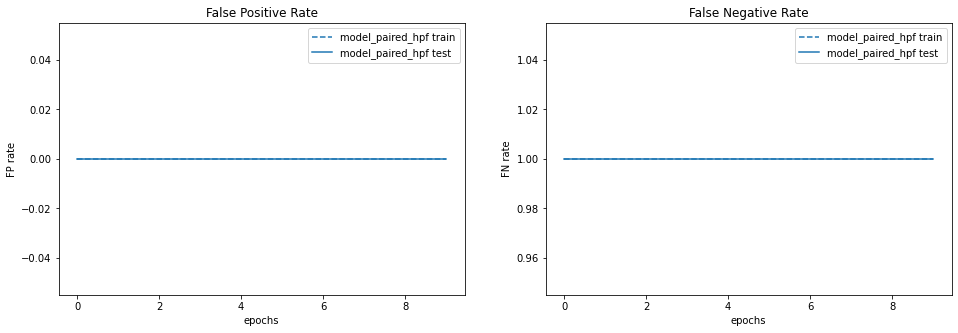

In [ ]:
show_results(model_paired_hpf = logs_paired_hpf)
show_type_errors(model_paired_hpf = logs_paired_hpf)

In [ ]:
print(logs_paired_hpf["test_fp"])
print(logs_paired_hpf["test_tp"])
print(logs_paired_hpf["test_fn"])
print(logs_paired_hpf["test_tn"])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4553, 4396, 4710, 4082, 4553, 3925, 4239, 4553, 4239, 4553]
[5495, 5652, 5338, 5966, 5495, 6123, 5809, 5495, 5809, 5495]


# XuNet

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

KV = torch.tensor([[-1,2,-2,2,-1],
		   [2,-6,8,-6,2],
		   [-2,8,-12,8,-2],
		   [2,-6,8,-6,2],
		   [-1,2,-2,2,-1]])/12.
KV = KV.view(1,1,5,5).to(device=device, dtype=torch.float)
KV = torch.autograd.Variable(KV, requires_grad=False)
print(KV.shape)

class XuNet(torch.nn.Module):
	def __init__(self):
		super(XuNet, self).__init__()


		self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2, bias=False)
		self.bn1 = torch.nn.BatchNorm2d(8)

		self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2, bias=False)
		self.bn2 = torch.nn.BatchNorm2d(16)

		self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0, bias=False)
		self.bn3 = torch.nn.BatchNorm2d(32)

		self.conv4 = torch.nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0, bias=False)
		self.bn4 = torch.nn.BatchNorm2d(64)

		self.conv5 = torch.nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0, bias=False)
		self.bn5 = torch.nn.BatchNorm2d(128)

		self.fc = torch.nn.Linear(128*1*1, 2)

		
	def forward(self, x):
		prep = torch.nn.functional.conv2d(x, KV, padding=2)

		out = torch.tanh(self.bn1(torch.abs(self.conv1(prep))))
		out = torch.nn.functional.avg_pool2d(out, kernel_size=5, stride=2, padding=2)

		out = torch.tanh(self.bn2(self.conv2(out)))
		out = torch.nn.functional.avg_pool2d(out, kernel_size=5, stride=2, padding=2)

		out = torch.nn.functional.relu(self.bn3(self.conv3(out)))
		out = torch.nn.functional.avg_pool2d(out, kernel_size=5, stride=2, padding=2)

		out = torch.nn.functional.relu(self.bn4(self.conv4(out)))
		out = torch.nn.functional.avg_pool2d(out, kernel_size=5, stride=2, padding=2)

		out = torch.nn.functional.relu(self.bn5(self.conv5(out)))
		out = torch.nn.functional.adaptive_avg_pool2d(out,(1,1))

		out = out.view(out.size(0), -1)
		out = self.fc(out)
		return out

torch.Size([1, 1, 5, 5])


In [ ]:
BATCH_SIZE=64
NUM_SAMPLES=10000
LR = 5e-3
EPOCHS = 30

xu_net = XuNet()

train_loader = torch.utils.data.DataLoader(bossbase_train, batch_size=BATCH_SIZE, shuffle=True)#, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(bossbase_test, batch_size=BATCH_SIZE, shuffle=True)#, sampler=test_sampler)

trainer = ModelTrainer(train_loader, test_loader, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(xu_net.parameters(), lr=LR)

In [ ]:
logs_xu = trainer.train(xu_net, optimizer, n_epochs=EPOCHS, n_samples_train=NUM_SAMPLES, n_samples_test=NUM_SAMPLES)

Start
Epoch:  1
train_loss:  0.654755711555481
train_accuracy:  0.6024084394904459
test_loss:  3.093311071395874
test_accuracy:  0.5326433121019108
Epoch:  2
train_loss:  0.5992498993873596
train_accuracy:  0.6398288216560509
test_loss:  1.6382200717926025
test_accuracy:  0.5225915605095541
Epoch:  3
train_loss:  0.6051095724105835
train_accuracy:  0.6563495222929936
test_loss:  1.2724462747573853
test_accuracy:  0.5490644904458599
Epoch:  4
train_loss:  0.6170477867126465
train_accuracy:  0.6503781847133758
test_loss:  1.2294198274612427
test_accuracy:  0.5311504777070064
Epoch:  5
train_loss:  0.5539154410362244
train_accuracy:  0.644406847133758
test_loss:  1.8329538106918335
test_accuracy:  0.5349323248407644
Epoch:  6
train_loss:  0.6792663335800171
train_accuracy:  0.660031847133758
test_loss:  1.8680089712142944
test_accuracy:  0.5185111464968153
Epoch:  7
train_loss:  0.5510712265968323
train_accuracy:  0.6649084394904459
test_loss:  0.8634796738624573
test_accuracy:  0.6264928

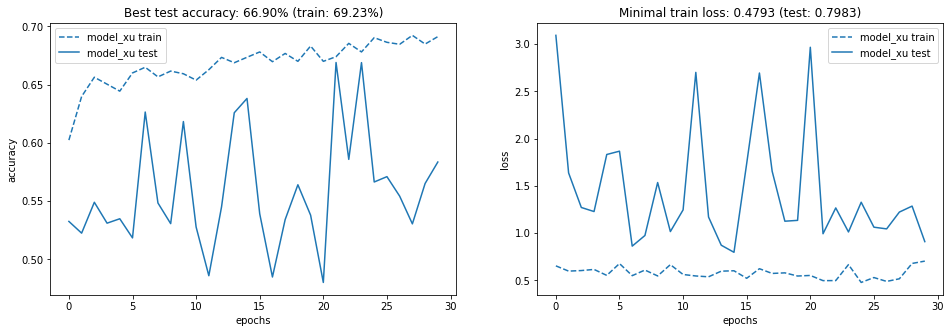

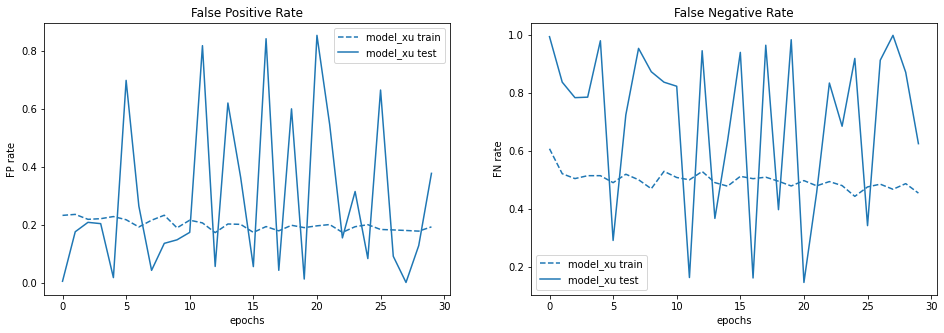

In [ ]:
#30 epochs
show_results(model_xu = logs_xu)
show_type_errors(model_xu = logs_xu)

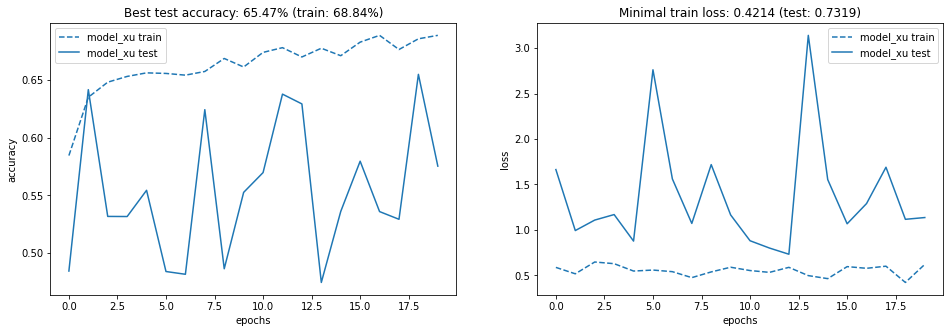

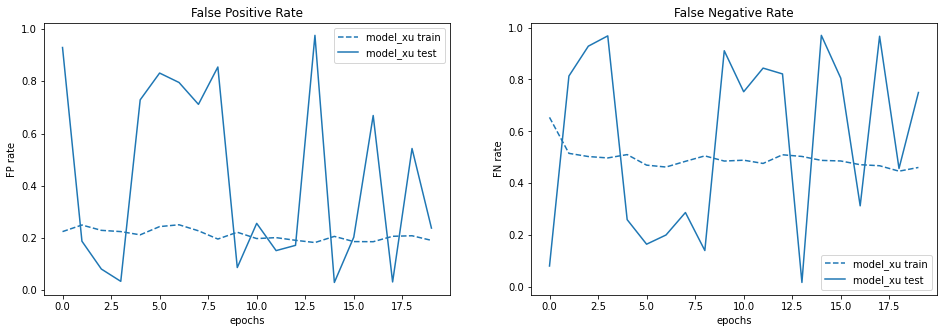

In [ ]:
# 20 epochs
show_results(model_xu = logs_xu)
show_type_errors(model_xu = logs_xu)

In [ ]:
print(logs_xu["train_fp"])
print(logs_xu["train_tp"])
print(logs_xu["train_fn"])
print(logs_xu["train_tn"]) 

[1540, 1351, 1311, 1210, 1214, 1233, 1093, 1230, 1099, 998]
[2032, 2172, 2197, 2124, 2107, 2226, 2131, 2237, 2202, 2112]
[2481, 2294, 2225, 2303, 2270, 2234, 2290, 2244, 2267, 2289]
[3995, 4231, 4315, 4411, 4457, 4355, 4534, 4337, 4480, 4649]


In [ ]:
train_sampler = RandomPairedSampler(bossbase_train)

In [ ]:
BATCH_SIZE=64
NUM_SAMPLES=10000
LR = 5e-3
EPOCHS = 20

xu_net_pairs = XuNet()

train_loader = torch.utils.data.DataLoader(bossbase_train, batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(bossbase_test, batch_size=BATCH_SIZE, shuffle=True)#, sampler=test_sampler)

trainer = ModelTrainer(train_loader, test_loader, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(xu_net_pairs.parameters(), lr=LR)

In [ ]:
logs_xu_pairs = trainer.train(xu_net_pairs, optimizer, n_epochs=EPOCHS, n_samples_train=NUM_SAMPLES, n_samples_test=NUM_SAMPLES)

Start
Epoch:  1
train_loss:  0.6482163667678833
train_accuracy:  0.6259952229299363
test_loss:  1.801498532295227
test_accuracy:  0.5243829617834395
Epoch:  2
test_loss:  1.1128207445144653
test_accuracy:  0.533140923566879
Epoch:  3
train_loss:  0.5154466032981873
train_accuracy:  0.65515525477707
test_loss:  0.9811572432518005
test_accuracy:  0.5640923566878981
Epoch:  4
train_loss:  0.7030042409896851
train_accuracy:  0.6590366242038217
test_loss:  1.2031476497650146
test_accuracy:  0.5513535031847133
Epoch:  5
train_loss:  0.5676885843276978
train_accuracy:  0.6643113057324841
test_loss:  1.8906255960464478
test_accuracy:  0.5319466560509554
Epoch:  6
train_loss:  0.5102534294128418
train_accuracy:  0.6667993630573248
test_loss:  1.1462563276290894
test_accuracy:  0.5940485668789809
Epoch:  7
train_loss:  0.5534060597419739
train_accuracy:  0.6754578025477707
test_loss:  3.18670392036438
test_accuracy:  0.5326433121019108
Epoch:  8
train_loss:  0.5307623147964478
train_accuracy:  0

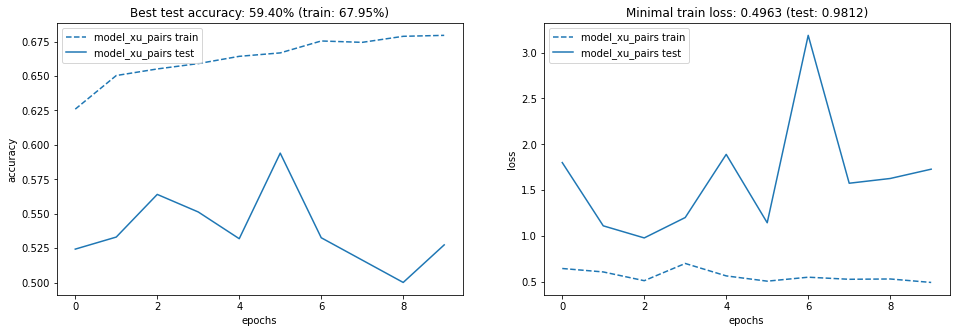

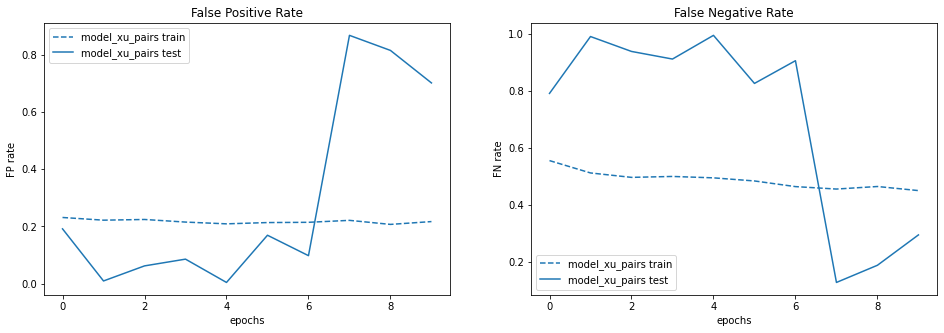

In [ ]:
show_results(model_xu_pairs = logs_xu_pairs)
show_type_errors(model_xu_pairs = logs_xu_pairs)

In [ ]:
from torchsummary import summary

In [ ]:
KV = torch.tensor([[-1,2,-2,2,-1],
		   [2,-6,8,-6,2],
		   [-2,8,-12,8,-2],
		   [2,-6,8,-6,2],
		   [-1,2,-2,2,-1]])/12.
KV = KV.view(1,1,5,5).to(device=device, dtype=torch.float)
KV = torch.autograd.Variable(KV, requires_grad=False)
net = XuNet().cuda()
summary(net, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             200
       BatchNorm2d-2          [-1, 8, 256, 256]              16
            Conv2d-3         [-1, 16, 128, 128]           3,200
       BatchNorm2d-4         [-1, 16, 128, 128]              32
            Conv2d-5           [-1, 32, 64, 64]             512
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 64, 32, 32]           2,048
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9          [-1, 128, 16, 16]           8,192
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Linear-11                    [-1, 2]             258
Total params: 14,906
Trainable params: 14,906
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/ba

In [ ]:
summary(model_hpf, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               HPF-1          [-1, 1, 256, 256]               0
            Conv2d-2         [-1, 16, 256, 256]             416
              Tanh-3         [-1, 16, 256, 256]               0
         AvgPool2d-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 30, 128, 128]          12,030
              Tanh-6         [-1, 30, 128, 128]               0
         AvgPool2d-7           [-1, 30, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]          24,032
              ReLU-9           [-1, 32, 64, 64]               0
        AvgPool2d-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
             ReLU-12           [-1, 64, 32, 32]               0
        AvgPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

#CNN + High-Path filer + Batch normalization

In [ ]:
cnn_norm = torch.nn.Sequential(
    torch.nn.Conv2d(1, 8, 5, stride=1, padding=2, bias=True),
    torch.nn.BatchNorm2d(8),
    torch.nn.Tanh(), 
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(8, 16, 5, stride=1, padding=2, bias=True),
    torch.nn.BatchNorm2d(16),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(16, 32, 5, stride=1, padding=2, bias=True),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=True),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=True),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(16),
    Squeeze()
)

classifier2 = torch.nn.Sequential(
    torch.nn.Linear(128, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 2)
)

In [ ]:
train_sampler = RandomPairedSampler(bossbase_train)

In [ ]:
BATCH_SIZE=64
NUM_SAMPLES=10000
LR = 5e-3
EPOCHS = 20

kernel = torch.tensor([
       [-1,2,-2,2,-1],
		   [2,-6,8,-6,2],
		   [-2,8,-12,8,-2],
		   [2,-6,8,-6,2],
		   [-1,2,-2,2,-1]])/12.

model_norm = torch.nn.Sequential(
     HPF(kernel),
     cnn_norm,
     classifier2
)

train_loader = torch.utils.data.DataLoader(bossbase_train, batch_size=BATCH_SIZE, shuffle=True)#, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(bossbase_test, batch_size=BATCH_SIZE, shuffle=True)#, sampler=test_sampler)

trainer = ModelTrainer(train_loader, test_loader, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model_norm.parameters(), lr=LR)

In [ ]:
summary(model_norm.cuda(), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               HPF-1          [-1, 1, 256, 256]               0
            Conv2d-2          [-1, 8, 256, 256]             208
       BatchNorm2d-3          [-1, 8, 256, 256]              16
              Tanh-4          [-1, 8, 256, 256]               0
         AvgPool2d-5          [-1, 8, 128, 128]               0
            Conv2d-6         [-1, 16, 128, 128]           3,216
       BatchNorm2d-7         [-1, 16, 128, 128]              32
              Tanh-8         [-1, 16, 128, 128]               0
         AvgPool2d-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]          12,832
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
        AvgPool2d-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
logs_cnn_norm = trainer.train(model_norm, optimizer, n_epochs=EPOCHS, n_samples_train=NUM_SAMPLES, n_samples_test=NUM_SAMPLES)

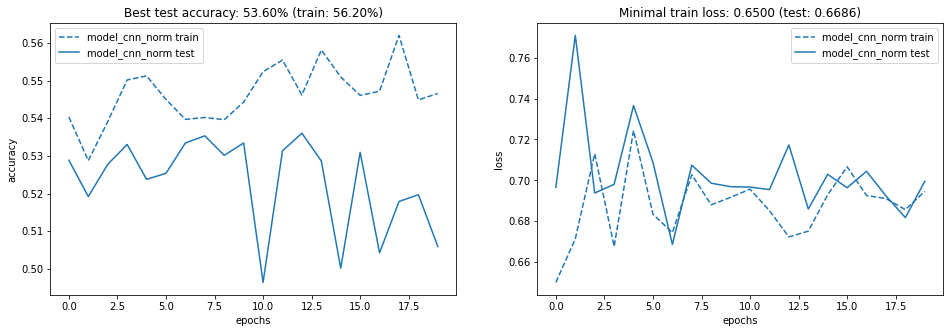

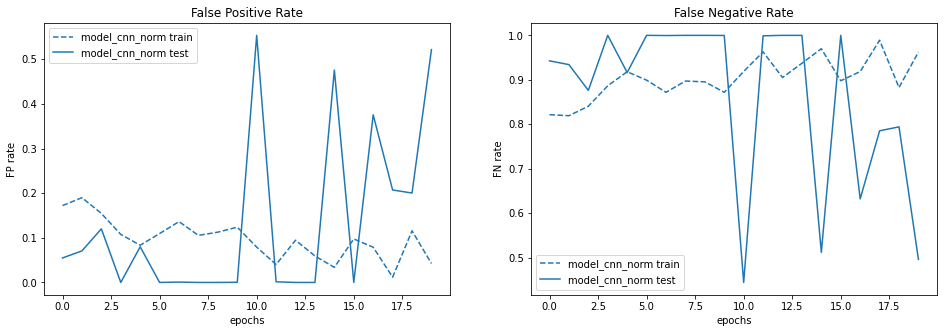

In [ ]:
#Without HPF and without sampler
show_results(model_cnn_norm = logs_cnn_norm)
show_type_errors(model_cnn_norm = logs_cnn_norm)

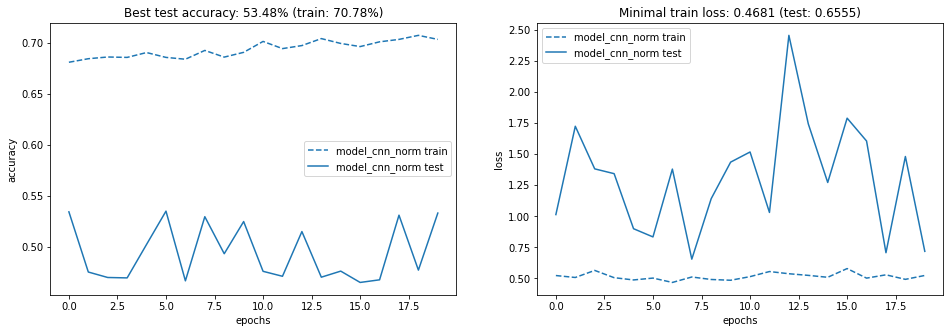

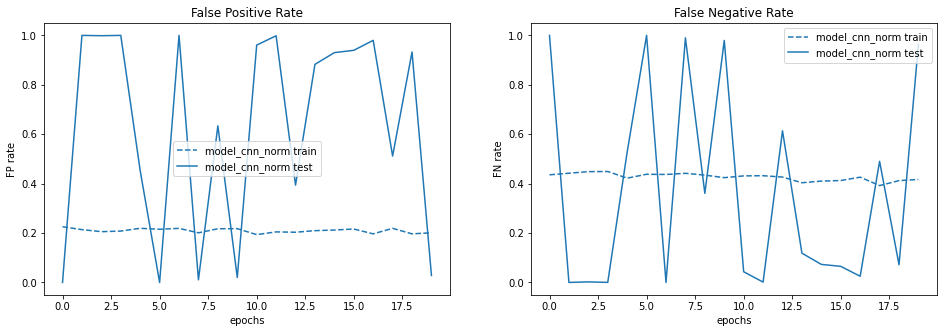

In [ ]:
# With sampler
show_results(model_cnn_norm = logs_cnn_norm)
show_type_errors(model_cnn_norm = logs_cnn_norm)

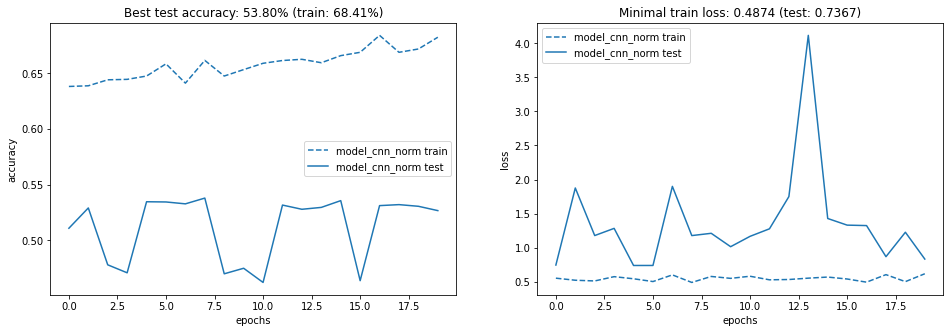

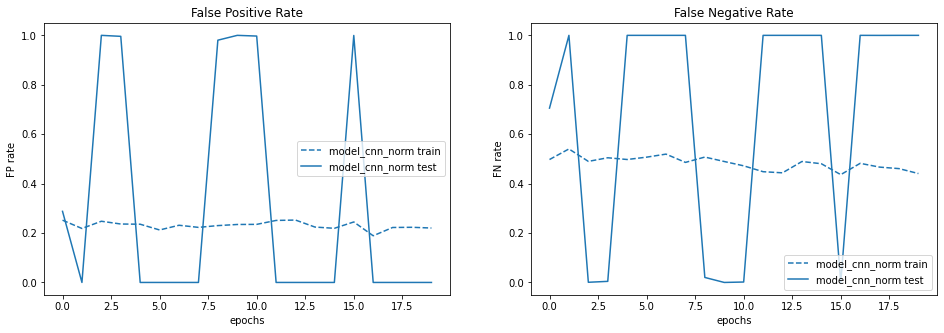

In [ ]:
show_results(model_cnn_norm = logs_cnn_norm)
show_type_errors(model_cnn_norm = logs_cnn_norm)

In [ ]:
print(logs_cnn_norm["train_tp"])
print(logs_cnn_norm["train_fp"])
print(logs_cnn_norm["train_tn"])
print(logs_cnn_norm["train_fn"])

[2258, 2049, 2287, 2208, 2251, 2170, 2136, 2269, 2183, 2255, 2372, 2460, 2483, 2249, 2297, 2553, 2254, 2383, 2394, 2481]
[1400, 1221, 1378, 1322, 1312, 1199, 1297, 1256, 1292, 1321, 1306, 1403, 1410, 1265, 1233, 1351, 1076, 1241, 1252, 1236]
[4155, 4370, 4186, 4269, 4256, 4447, 4307, 4379, 4324, 4310, 4250, 4187, 4175, 4378, 4394, 4168, 4620, 4338, 4357, 4376]
[2235, 2408, 2197, 2249, 2229, 2232, 2308, 2144, 2249, 2162, 2120, 1998, 1980, 2156, 2124, 1976, 2098, 2086, 2045, 1955]


#CNN Regularized (64D feature vector)

In [ ]:
cnn_reg = torch.nn.Sequential(
    torch.nn.Conv2d(1, 8, 5, stride=1, padding=2, bias=False),
    torch.nn.BatchNorm2d(8),
    torch.nn.Tanh(), 
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(8, 16, 5, stride=1, padding=2, bias=False),
    torch.nn.BatchNorm2d(16),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(16, 32, 1, stride=1, padding=0, bias=False),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(32, 64, 1, stride=1, padding=0, bias=False),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(32),
    Squeeze()
)

classifier_reg = torch.nn.Sequential(
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)

In [ ]:
BATCH_SIZE=64
NUM_SAMPLES=10000
LR = 5e-3
EPOCHS = 20

kernel = torch.tensor([
       [-1,2,-2,2,-1],
		   [2,-6,8,-6,2],
		   [-2,8,-12,8,-2],
		   [2,-6,8,-6,2],
		   [-1,2,-2,2,-1]])/12.

model_reg = torch.nn.Sequential(
     HPF(kernel),
     cnn_reg,
     classifier_reg
)

train_loader = torch.utils.data.DataLoader(bossbase_train, batch_size=BATCH_SIZE, shuffle=True)#, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(bossbase_test, batch_size=BATCH_SIZE, shuffle=True)#, sampler=test_sampler)

trainer = ModelTrainer(train_loader, test_loader, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model_reg.parameters(), lr=LR)

In [ ]:
summary(model_reg.cuda(), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               HPF-1          [-1, 1, 256, 256]               0
            Conv2d-2          [-1, 8, 256, 256]             200
       BatchNorm2d-3          [-1, 8, 256, 256]              16
              Tanh-4          [-1, 8, 256, 256]               0
         AvgPool2d-5          [-1, 8, 128, 128]               0
            Conv2d-6         [-1, 16, 128, 128]           3,200
       BatchNorm2d-7         [-1, 16, 128, 128]              32
              Tanh-8         [-1, 16, 128, 128]               0
         AvgPool2d-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]             512
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
        AvgPool2d-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
logs_cnn_reg = trainer.train(model_reg, optimizer, n_epochs=EPOCHS, n_samples_train=NUM_SAMPLES, n_samples_test=NUM_SAMPLES)

Start
Epoch:  1
train_loss:  0.6594752669334412
train_accuracy:  0.5654856687898089
test_loss:  0.7699171900749207
test_accuracy:  0.46626194267515925
Epoch:  2
train_loss:  0.6311469674110413
train_accuracy:  0.5945461783439491
test_loss:  3.810911178588867
test_accuracy:  0.46576433121019106
Epoch:  3
train_loss:  0.6329918503761292
train_accuracy:  0.5879777070063694
test_loss:  0.7585085034370422
test_accuracy:  0.4967157643312102
Epoch:  4
train_loss:  0.6544135212898254
train_accuracy:  0.6060907643312102
test_loss:  1.151161551475525
test_accuracy:  0.5372213375796179
Epoch:  5
train_loss:  0.6211276054382324
train_accuracy:  0.6294785031847133
test_loss:  0.7658953070640564
test_accuracy:  0.6327627388535032
Epoch:  6
train_loss:  0.6208248734474182
train_accuracy:  0.6285828025477707
test_loss:  1.009959101676941
test_accuracy:  0.5233877388535032
Epoch:  7
train_loss:  0.6326654553413391
train_accuracy:  0.6258957006369427
test_loss:  0.9957317113876343
test_accuracy:  0.5083

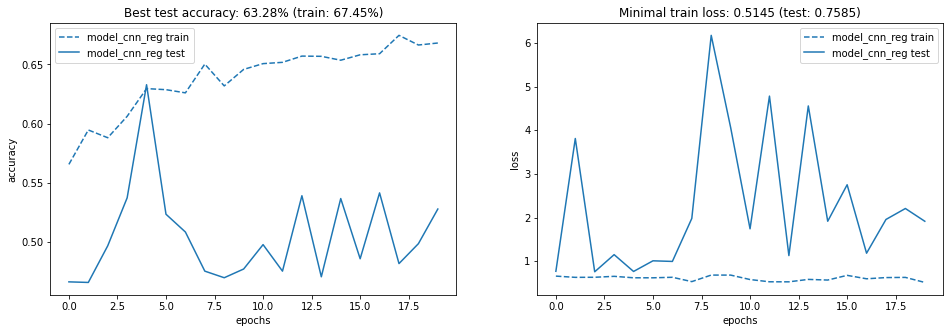

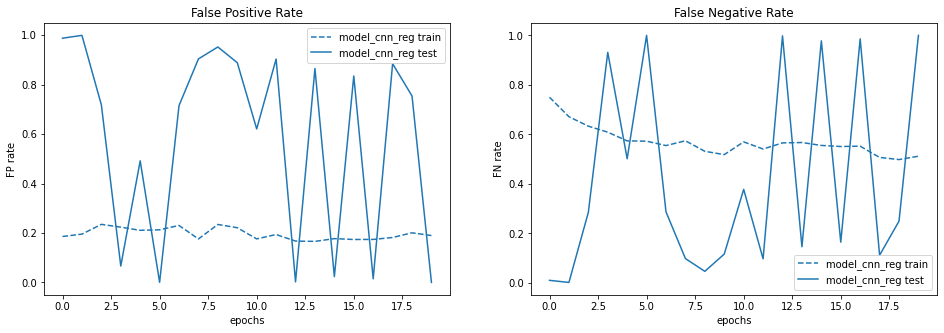

In [ ]:
#With ReLU
show_results(model_cnn_reg = logs_cnn_reg)
show_type_errors(model_cnn_reg = logs_cnn_reg)

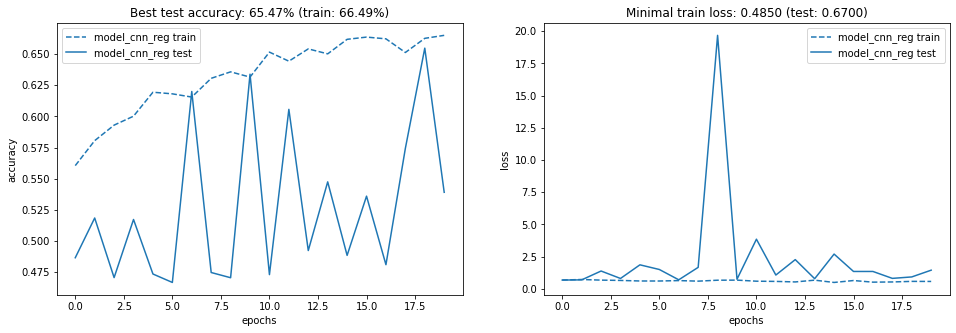

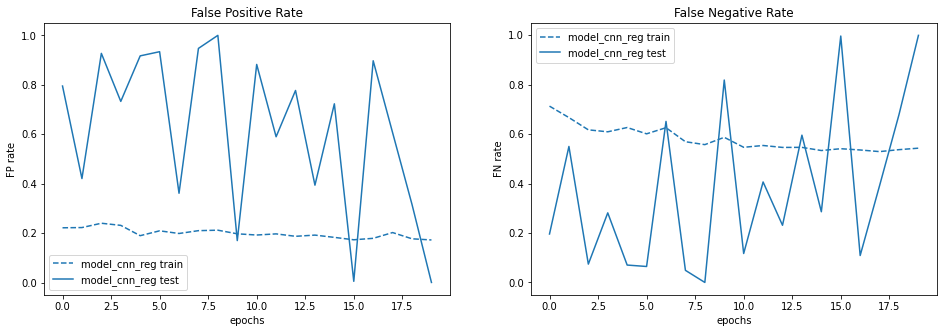

In [ ]:
show_results(model_cnn_reg = logs_cnn_reg)
show_type_errors(model_cnn_reg = logs_cnn_reg)

#CNN regularized (128D feature vector)

In [ ]:
cnn_reg2 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 8, 5, stride=1, padding=2, bias=False),
    torch.nn.BatchNorm2d(8),
    torch.nn.Tanh(), 
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(8, 16, 5, stride=1, padding=2, bias=False),
    torch.nn.BatchNorm2d(16),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(16, 32, 1, stride=1, padding=0, bias=False),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(32, 64, 1, stride=1, padding=0, bias=False),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(64, 100, 1, stride=1, padding=0, bias=False),
    torch.nn.BatchNorm2d(100),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(16),
    Squeeze()
)

classifier_reg2 = torch.nn.Sequential(
    torch.nn.ReLU(),
    torch.nn.Linear(100, 2)
)

NameError: ignored

In [ ]:
BATCH_SIZE=64
NUM_SAMPLES=10000
LR = 5e-3
EPOCHS = 20

kernel = torch.tensor([
       [-1,2,-2,2,-1],
		   [2,-6,8,-6,2],
		   [-2,8,-12,8,-2],
		   [2,-6,8,-6,2],
		   [-1,2,-2,2,-1]])/12.

model_reg2 = torch.nn.Sequential(
     HPF(kernel),
     cnn_reg2,
     classifier_reg2
)

train_loader = torch.utils.data.DataLoader(bossbase_train, batch_size=BATCH_SIZE, shuffle=True)#, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(bossbase_test, batch_size=BATCH_SIZE, shuffle=True)#, sampler=test_sampler)

trainer = ModelTrainer(train_loader, test_loader, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model_reg2.parameters(), lr=LR)

In [ ]:
summary(model_reg2.cuda(), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               HPF-1          [-1, 1, 256, 256]               0
            Conv2d-2          [-1, 8, 256, 256]             200
       BatchNorm2d-3          [-1, 8, 256, 256]              16
              Tanh-4          [-1, 8, 256, 256]               0
         AvgPool2d-5          [-1, 8, 128, 128]               0
            Conv2d-6         [-1, 16, 128, 128]           3,200
       BatchNorm2d-7         [-1, 16, 128, 128]              32
              Tanh-8         [-1, 16, 128, 128]               0
         AvgPool2d-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]             512
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
        AvgPool2d-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
logs_cnn_reg2 = trainer.train(model_reg2, optimizer, n_epochs=EPOCHS, n_samples_train=NUM_SAMPLES, n_samples_test=NUM_SAMPLES)

Start
Epoch:  1
train_loss:  0.7266751527786255
train_accuracy:  0.580812101910828
test_loss:  0.857148289680481
test_accuracy:  0.4807921974522293
Epoch:  2
train_loss:  0.5982590317726135
train_accuracy:  0.600218949044586
test_loss:  0.9610663056373596
test_accuracy:  0.5379179936305732
Epoch:  3
train_loss:  0.6917147040367126
train_accuracy:  0.6127587579617835
test_loss:  0.9433416724205017
test_accuracy:  0.5362261146496815
Epoch:  4
train_loss:  0.6220951080322266
train_accuracy:  0.6359474522292994
test_loss:  5.299290657043457
test_accuracy:  0.4817874203821656
Epoch:  5
train_loss:  0.620832085609436
train_accuracy:  0.6471934713375797
test_loss:  10.529308319091797
test_accuracy:  0.46765525477707004
Epoch:  6
train_loss:  0.5563241243362427
train_accuracy:  0.6531648089171974
test_loss:  7.4764275550842285
test_accuracy:  0.476015127388535
Epoch:  7
train_loss:  0.5526277422904968
train_accuracy:  0.6494824840764332
test_loss:  3.84332013130188
test_accuracy:  0.4712380573

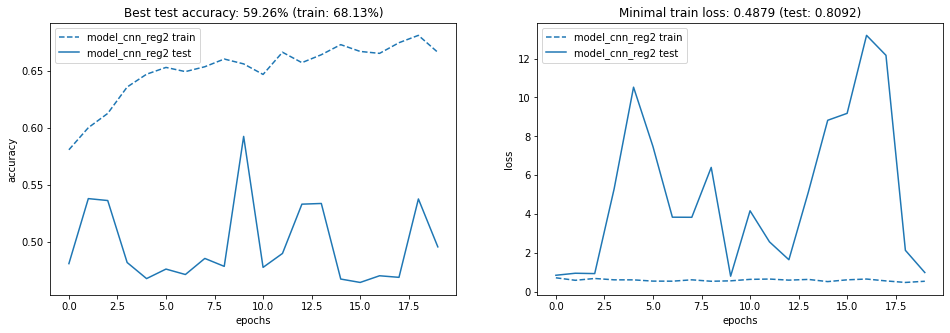

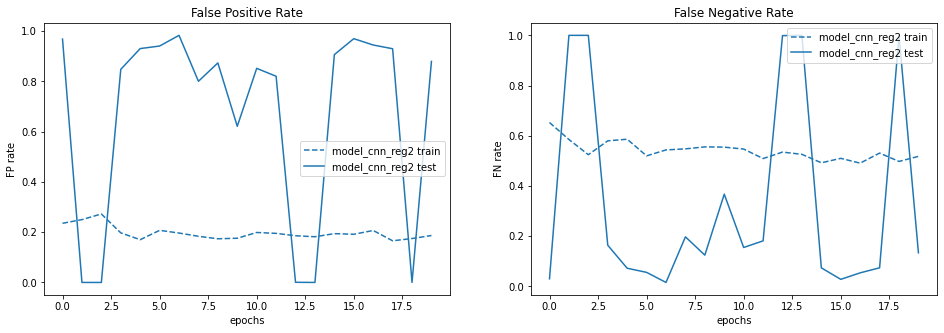

In [ ]:
#100d
show_results(model_cnn_reg2 = logs_cnn_reg2)
show_type_errors(model_cnn_reg2 = logs_cnn_reg2)

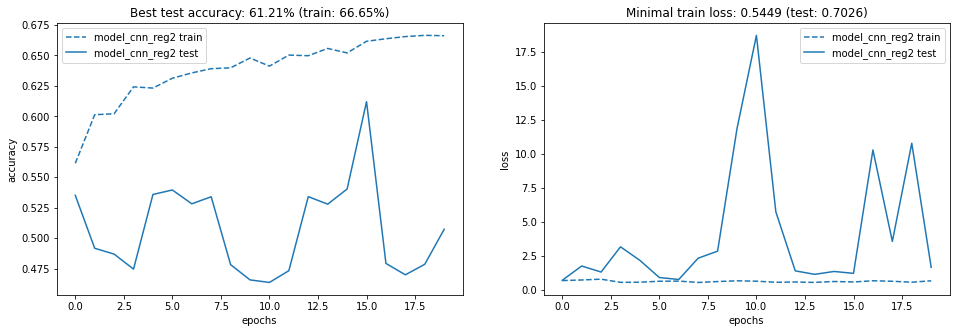

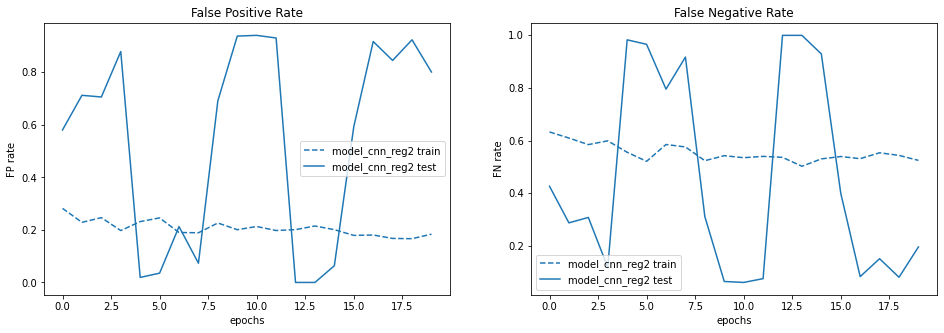

In [ ]:
show_results(model_cnn_reg2 = logs_cnn_reg2)
show_type_errors(model_cnn_reg2 = logs_cnn_reg2)

# More HPFs

## Filters

In [ ]:
filter_class_1 = [
  np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 1],
    [0, -1, 0],
    [0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0],
    [1, -1, 0],
    [0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0],
    [0, -1, 1],
    [0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0],
    [0, -1, 0],
    [1, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0],
    [0, -1, 0],
    [0, 1, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
  ], dtype=np.float32)
]


filter_class_2 = [
  np.array([
    [1, 0, 0],
    [0, -2, 0],
    [0, 0, 1]
  ], dtype=np.float32),
  np.array([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 1],
    [0, -2, 0],
    [1, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
  ], dtype=np.float32),
]


filter_class_3 = [
  np.array([
    [-1, 0, 0, 0, 0],
    [0, 3, 0, 0, 0],
    [0, 0, -3, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, -1, 0, 0],
    [0, 0, 3, 0, 0],
    [0, 0, -3, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0, 0, -1],
    [0, 0, 0, 3, 0],
    [0, 0, -3, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 1, -3, 3, -1],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, -3, 0, 0],
    [0, 0, 0, 3, 0],
    [0, 0, 0, 0, -1]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, -3, 0, 0],
    [0, 0, 3, 0, 0],
    [0, 0, -1, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, -3, 0, 0],
    [0, 3, 0, 0, 0],
    [-1, 0, 0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [-1, 3, -3, 1, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
  ], dtype=np.float32)
]


filter_edge_3x3 = [
  np.array([
    [-1, 2, -1],
    [2, -4, 2],
    [0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 2, -1],
    [0, -4, 2],
    [0, 2, -1]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0],
    [2, -4, 2],
    [-1, 2, -1]
  ], dtype=np.float32),
  np.array([
    [-1, 2, 0],
    [2, -4, 0],
    [-1, 2, 0]
  ], dtype=np.float32),
]

filter_edge_5x5 = [
  np.array([
    [-1, 2, -2, 2, -1],
    [2, -6, 8, -6, 2],
    [-2, 8, -12, 8, -2],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
  ], dtype=np.float32),
  np.array([
    [0, 0, -2, 2, -1],
    [0, 0, 8, -6, 2],
    [0, 0, -12, 8, -2],
    [0, 0, 8, -6, 2],
    [0, 0, -2, 2, -1]
  ], dtype=np.float32),
  np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [-2, 8, -12, 8, -2],
    [2, -6, 8, -6, 2],
    [-1, 2, -2, 2, -1]
  ], dtype=np.float32),
  np.array([
    [-1, 2, -2, 0, 0],
    [2, -6, 8, 0, 0],
    [-2, 8, -12, 0, 0],
    [2, -6, 8, 0, 0],
    [-1, 2, -2, 0, 0]
  ], dtype=np.float32),
]

square_3x3 = np.array([
  [-1, 2, -1],
  [2, -4, 2],
  [-1, 2, -1]
], dtype=np.float32)

square_5x5 = np.array([
  [-1, 2, -2, 2, -1],
  [2, -6, 8, -6, 2],
  [-2, 8, -12, 8, -2],
  [2, -6, 8, -6, 2],
  [-1, 2, -2, 2, -1]
], dtype=np.float32)


all_hpf_list = filter_class_1 + filter_class_2 + filter_class_3 + filter_edge_3x3 + filter_edge_5x5 + [square_3x3, square_5x5]

hpf_3x3_list = filter_class_1 + filter_class_2 + filter_edge_3x3 + [square_3x3]
hpf_5x5_list = filter_class_3 + filter_edge_5x5 + [square_5x5]

normalized_filter_class_2 = [hpf / 2 for hpf in filter_class_2]
normalized_filter_class_3 = [hpf / 3 for hpf in filter_class_3]
normalized_filter_edge_3x3 = [hpf / 4 for hpf in filter_edge_3x3]
normalized_square_3x3 = square_3x3 / 4
normalized_filter_edge_5x5 = [hpf / 12 for hpf in filter_edge_5x5]
normalized_square_5x5 = square_5x5 / 12

all_normalized_hpf_list = filter_class_1 + normalized_filter_class_2 + normalized_filter_class_3 + \
 normalized_filter_edge_3x3 + normalized_filter_edge_5x5 + [normalized_square_3x3, normalized_square_5x5]

normalized_hpf_3x3_list = filter_class_1 + normalized_filter_class_2 + normalized_filter_edge_3x3 + [normalized_square_3x3]
normalized_hpf_5x5_list = normalized_filter_class_3 + normalized_filter_edge_5x5 + [normalized_square_5x5]

normalized_3x3_list = normalized_filter_edge_3x3 + [normalized_square_3x3]
normalized_5x5_list = normalized_filter_edge_5x5 + [normalized_square_5x5]

## Module

In [ ]:
class HPF2(torch.nn.Module):
    def __init__(self):
        super(HPF2, self).__init__()

        # Load 30 SRM Filters
        all_hpf_list_5x5 = []

        for hpf_item in all_normalized_hpf_list:
            if hpf_item.shape[0] == 3:
                hpf_item = np.pad(hpf_item, pad_width=((1, 1), (1, 1)), mode='constant')

            all_hpf_list_5x5.append(hpf_item)

        hpf_weight = torch.nn.Parameter(torch.Tensor(all_hpf_list_5x5).view(30, 1, 5, 5), requires_grad=False)

        self.hpf = torch.nn.Conv2d(1, 30, kernel_size=5, padding=2, bias=False)
        self.hpf.weight = hpf_weight

    def forward(self, input):
        output = self.hpf(input)
        return output

#CNN

In [ ]:
cnn_hpfs = torch.nn.Sequential(
    torch.nn.Conv2d(30, 30, 5, stride=1, padding=2, bias=True),
    torch.nn.BatchNorm2d(30),
    torch.nn.Tanh(), 
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(30, 32 , 5, stride=1, padding=2, bias=True),
    torch.nn.BatchNorm2d(32),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(32, 64, 5, stride=1, padding=2, bias=True),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(5, stride=2, padding=2),
    torch.nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=True),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),    
    torch.nn.AvgPool2d(32),
    Squeeze()
)

classifier3 = torch.nn.Sequential(
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2)
)

In [ ]:
BATCH_SIZE=64
NUM_SAMPLES=10000
LR = 5e-3
EPOCHS = 10

kernel = torch.tensor([
       [-1,2,-2,2,-1],
		   [2,-6,8,-6,2],
		   [-2,8,-12,8,-2],
		   [2,-6,8,-6,2],
		   [-1,2,-2,2,-1]])/12.

model_hpfs = torch.nn.Sequential(
      HPF2(),
      cnn_hpfs,
      classifier3
)

train_loader = torch.utils.data.DataLoader(bossbase_train, batch_size=BATCH_SIZE, shuffle=True)#, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(bossbase_test, batch_size=BATCH_SIZE, shuffle=True)#, sampler=test_sampler)

trainer = ModelTrainer(train_loader, test_loader, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model_hpfs.parameters(), lr=LR)

In [ ]:
summary(model_hpfs.cuda(), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 30, 256, 256]             750
              HPF2-2         [-1, 30, 256, 256]               0
            Conv2d-3         [-1, 30, 256, 256]          22,530
       BatchNorm2d-4         [-1, 30, 256, 256]              60
              Tanh-5         [-1, 30, 256, 256]               0
         AvgPool2d-6         [-1, 30, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]          24,032
       BatchNorm2d-8         [-1, 32, 128, 128]              64
              Tanh-9         [-1, 32, 128, 128]               0
        AvgPool2d-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          51,264
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
        AvgPool2d-14           [-1, 64,

In [ ]:
logs_cnn_hpfs = trainer.train(model_hpfs, optimizer, n_epochs=EPOCHS, n_samples_train=NUM_SAMPLES, n_samples_test=NUM_SAMPLES)

Start
Epoch:  1
train_loss:  0.6774902939796448
train_accuracy:  0.5318471337579618
test_loss:  0.6733607053756714
test_accuracy:  0.5318471337579618
Epoch:  2
train_loss:  0.689801812171936
train_accuracy:  0.5440883757961783
test_loss:  0.701488196849823
test_accuracy:  0.5360270700636943
Epoch:  3
train_loss:  0.6925511360168457
train_accuracy:  0.5549363057324841
test_loss:  0.6881701350212097
test_accuracy:  0.5383160828025477
Epoch:  4
train_loss:  0.6889200806617737
train_accuracy:  0.5503582802547771
test_loss:  0.6923152208328247
test_accuracy:  0.5302547770700637
Epoch:  5
train_loss:  0.6575489044189453
train_accuracy:  0.5565286624203821
test_loss:  0.6429225206375122
test_accuracy:  0.53234474522293
Epoch:  6
train_loss:  0.7053643465042114
train_accuracy:  0.5627985668789809
test_loss:  0.7108786702156067
test_accuracy:  0.5399084394904459
Epoch:  7
train_loss:  0.6812759041786194
train_accuracy:  0.5503582802547771
test_loss:  0.6791825294494629
test_accuracy:  0.5308519